# NLP Application - Restaurant Review Analysis 👨‍🍳
## By BROSSEAU Alexandre & COGORDAN Alexandre

In [98]:
# Our imports

import nltk
import requests
import time
import pandas as pd
import os
import re
import gensim
import gensim.corpora as corpora
import spacy
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import streamlit as st
import torch
import numpy as np
import tensorflow as tf
import gensim.downloader as api
import tensorflow_hub as hub
import nlpaug.augmenter.word as naw
import random
import xgboost as xgb
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from textblob import TextBlob
from collections import Counter
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, AutoModel, AutoTokenizer
from langchain import PromptTemplate, LLMChain
from dotenv import find_dotenv, load_dotenv
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, Word2Vec, KeyedVectors
from sklearn.manifold import TSNE
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorboard.plugins import projector
from gensim.models.phrases import Phrases, Phraser
from gensim.models.word2vec import LineSentence
from tensorboard.plugins import projector
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Model, Sequential
from scipy.spatial.distance import euclidean, cosine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from nlpaug.util import Action
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# We set a random seed
np.random.seed(42)

# We load our environment variables - API, HuggingFace, OPENAI keys
load_dotenv()

True

## Loading our dataset

com1: We're re-using the csv files that had previously ran analysis so that we avoid running the calculations multiple times and waste time on computational power.

In [99]:
df = pd.read_csv('yelp_reviews.csv')

# We drop duplicates and null values
df.drop_duplicates(inplace=True)
df.dropna(subset=['text', 'rating', 'location'], inplace=True)

## Pre-processing

In [100]:
# Translation pipeline
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-zh-en")
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].astype(str)

# Check if text contains Chinese characters
def contains_chinese(text):
    return bool(re.search('[\u4e00-\u9fff]', text))

# Translation function (from Chinese to English)
def translate_text(text):
    if contains_chinese(text):
        return translator(text)[0]['translation_text']
    else:
        return text
    
# We remove special characters/punctuation whilst keeping characters with accents since their meaning is important in French restaurants reviews
def remove_special_characters(text):
    pattern = r"[^\w\séèàçêôœ]"
    
    # We substitute matched characters with an empty string
    cleaned_text = re.sub(pattern, '', text)
    
    return cleaned_text
    
# Lemmatisation & Tokenisation function
def tokenisation(reviews, allowed_postags=["NOUN", "ADJ", "VERBS", "ADV"]):
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

    reviews_out = []
    tokens = []

    for review in reviews:
        doc = nlp(review) 
        reviews_out.append(" ".join([token.lemma_ for token in doc if token.pos_ in allowed_postags and token.lemma_ not in stop_words]))
    
    for text in reviews_out:
        new = gensim.utils.simple_preprocess(text, deacc=False) # We do not remove the accent marks because we deem them important for French restaurants reviews
        tokens.append(new)

    return tokens

# Preprocessing function - which regroups all of the previous steps too
def preprocessing(text):
    # Translation
    translated_text = translate_text(str(text))

    # We remove special characters/punctuation
    corrected_text = remove_special_characters(translated_text)

    # Corrected spelling on lower case text
    cleaned_text = str(TextBlob(corrected_text.lower()).correct())

    return cleaned_text

# Apply preprocessing and tokenisation
df['cleaned_text'] = df['text'].apply(preprocessing)
df['tokens'] = tokenisation(df['cleaned_text'])

## We review the most frequent words 

com2: This allows us to get an understanding of the most frequent words found in reviews for each restaurant. This gives a broad introduction to the feeling people get in a specific restaurant.

In [101]:
review_frequent_words = {}

def get_frequency(restaurant_id):

    # Word Frequency Analysis
    all_words = [word for tokens in df[df['restaurant_id'] == restaurant_id]['tokens'] for word in tokens]
    word_freq = Counter(all_words)

    # Sort the word frequency in descending order
    word_freq = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True))

    # N-gram Analysis
    bigrams = ngrams(all_words, 2)
    bigram_freq = Counter(bigrams)

    # Sort the bigram frequency in descending order
    bigram_freq = dict(sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True))

    # Tri-gram Analysis
    trigrams = ngrams(all_words, 3)
    trigram_freq = Counter(trigrams)

    # Sort the trigram frequency in descending order
    trigram_freq = dict(sorted(trigram_freq.items(), key=lambda x: x[1], reverse=True))

    return [word_freq, bigram_freq, trigram_freq]

# We create a dictionary with the restaurant_id as key and the frequency of words, bigrams and trigrams as values
for restaurant_id in df['restaurant_id']:
    review_frequent_words[restaurant_id] = get_frequency(restaurant_id)

review_frequent_words_df = pd.DataFrame.from_dict(review_frequent_words, orient='index', columns=['word_freq', 'bigram_freq', 'trigram_freq'])
review_frequent_words_df

,word_freq,bigram_freq,trigram_freq
1,"{'time': 5, 'service': 3, 'food': 3, 'amazing'...","{('top', 'tier'): 2, ('amazing', 'service'): 1...","{('amazing', 'service', 'attentive'): 1, ('ser..."
2,"{'food': 6, 'service': 4, 'life': 3, 'heart': ...","{('heart', 'belly'): 1, ('belly', 'happily'): ...","{('heart', 'belly', 'happily'): 1, ('belly', '..."
3,"{'food': 6, 'service': 5, 'time': 4, 'great': ...","{('first', 'time'): 2, ('food', 'good'): 2, ('...","{('review', 'private', 'party'): 1, ('private'..."
4,"{'restaurant': 3, 'food': 3, 'pm': 3, 'great':...","{('thoughtful', 'son'): 1, ('son', 'generous')...","{('thoughtful', 'son', 'generous'): 1, ('son',..."
5,"{'service': 3, 'food': 3, 'experience': 3, 'go...","{('great', 'thing'): 1, ('thing', 'place'): 1,...","{('great', 'thing', 'place'): 1, ('thing', 'pl..."
...,...,...,...
58,"{'service': 7, 'amazing': 4, 'experience': 3, ...","{('dining', 'experience'): 2, ('demand', 'rive...","{('demand', 'river', 'floor'): 1, ('river', 'f..."
59,"{'dining': 4, 'experience': 3, 'art': 3, 'love...","{('dining', 'experience'): 2, ('ten', 'board')...","{('ten', 'board', 'honestly'): 1, ('board', 'h..."
60,"{'food': 4, 'server': 3, 'great': 3, 'alliance...","{('alliance', 'great'): 2, ('service', 'recent...","{('service', 'recent', 'server'): 1, ('recent'..."
61,"{'service': 4, 'friendly': 3, 'course': 3, 're...","{('favorite', 'restaurant'): 2, ('kid', 'frien...","{('kid', 'friendly', 'actually'): 1, ('friendl..."


## Topic Modelling

com3: We regroup similar words together to form topics. This will be useful for our users who will be able to choose the topic that is more important to them. We'll then choose the reviews that have the specific tokens found in the topics chosen to give the user the restaurant with the criteria they wish to have.

In [102]:
# We convert the tokens into tuples where we'll have the word index (its placement on the map) and its frequency
id2word = corpora.Dictionary(df['tokens'])
corpus = [id2word.doc2bow(text) for text in df['tokens']]

# We create the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=10,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

# We visualise the topics
pyLDAvis.enable_notebook(local=True)
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds', R=10)
pyLDAvis.display(vis)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

com4: The visualization is well-constructed. It provides us with a high-level overview of the topics and allows for an interactive exploration of the terms that define each topic.
The map shows a good separation of topics which suggests distinct themes with salient terms captured by the model.
The presence of both common and specific terms within the topics suggests the model is effectively capturing the range of discourse present in the data which we usually find in reviews.
The distance between each theme suggests that the themes are diverse yet distinct.

## Using themes

com5: We proceed to create a dictionary to rename the topics based on the top 5 keywords of each topic. This will allow us to classify the review into themes that the user will be able to use. This will work by looking to see if the reviews contains the corresponding keywords of the topics. 

In [103]:
def get_topic_distribution(lda_model, bow):
    return lda_model.get_document_topics(bow, minimum_probability=0)

# We get the topic distribution for each review
df['topic_distribution'] = [get_topic_distribution(lda_model, corpus[i]) for i in range(len(df))]

# We get the top topics for each review
def get_top_topics(topic_distribution, num_topics=5):
    # Sort the topics by probability and select the top ones
    return sorted(topic_distribution, key=lambda x: x[1], reverse=True)[:num_topics]

df['top_topics'] = df['topic_distribution'].apply(lambda x: get_top_topics(x, 11 - 1))

# We label the topics
def label_topics(topic_list, lda_model):
    labels = []
    for topic_id, _ in topic_list:
        # Get the top words in the topic
        words = lda_model.show_topic(topic_id, 5)
        # Create a label (e.g., by joining the top words)
        label = [word for word, prob in words]
        labels.append(label)
    return labels

# We create a dictionary with the labels as keys and the words as values
def topicise(labels, label_dict):
    topics = []

    for topic_list in labels:
        for key, value in label_dict.items():
            if set(topic_list) == set(value):
                topics.append(key)

    return topics

# We label the topics
label_dict = {
    'Quality of Food & Service' : ['service', 'food', 'restaurant', 'good', 'great'],
    'French Dining Experience' : ['dinner', 'meal', 'french', 'reservation', 'little'],
    'Atmosphere' : ['speak', 'dining', 'menu', 'experience', 'soup'],
    'Price' : ['course', 'table', 'thing', 'life', 'party'],
    'Special Occasions' : ['birthday', 'time', 'family', 'really', 'warm'],
    'Ambience' : ['experience', 'overall', 'kiss', 'attentive', 'fantastic'],
    'Dining Experience' : ['experience', 'overall', 'kiss', 'attentive', 'fantastic'],
    'Staff' : ['year', 'last', 'time', 'first', 'second'],
    'Menu' : ['atmosphere', 'area', 'bit', 'high', 'mummy'],
    'Drinks' : ['way', 'incredible', 'class', 'wall', 'mood'] 
}

df['top_topic_labels'] = df['top_topics'].apply(lambda x: label_topics(x, lda_model))
df['topics'] = df['top_topic_labels'].apply(lambda x: topicise(x, label_dict))
df.drop(columns=['topic_distribution', 'top_topics'], inplace=True)

## BERT - Sentiment analysis & Generation

com6: We've decided to go with this: BERT for Text Classification: Given its context-aware nature and superior performance in understanding nuances, BERT is generally the better choice for text classification.
Word2Vec for Semantic Search: For semantic search tasks, Word2Vec's efficiency and effectiveness in finding similar words make it a strong choice.
We also used BERT in our advantage to generate new reviews and fix the imbalance issue we have with our reviews. From our experiments, we've realised that the training process for our word2vec and td-idf model was skewed. This was caused by the large amount of initial positive reviews compared to the initial neutral and negative reviews. Therefore, we've used generation by using a context augmenter on our previously inserted negative and neutral reviews. This deeply improved the cohesion of our models.

In [93]:
# Load the tokenizer and model
tokeniser = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

# Sentiment analysis function
def sentiment_score(review):
    tokens = tokeniser.encode(review, return_tensors="pt")
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

# Application to the DataFrame
df['sentiment'] = df['text'].apply(lambda x: sentiment_score(x))

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


com7: We've carried out this sentiment analysis by using the twitter-roberta-base-sentiment model. This will ouput values as such:
* 1: negative sentiment
* 2: neutral sentiment
* 3: positive sentiment 

In [94]:
# We're going to incrase the number of negative and neutral reviews to balance the dataset using text-augmentation and back-translation.
context_aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute", aug_p=0.2)

# Translation pipelines for back-translation
english_to_french = pipeline("translation", model="Helsinki-NLP/opus-mt-en-fr")
french_to_english = pipeline("translation", model="Helsinki-NLP/opus-mt-fr-en")

# Back-translation function
def back_translate(text):
    # Translate to French
    french_text = english_to_french(text)[0]['translation_text']
    # Translate back to English
    back_translated_text = french_to_english(french_text)[0]['translation_text']
    return back_translated_text

def generate_new_reviews(text):
    # text = back_translate(text)
    text = context_aug.augment(text)
    # text = back_translate(text)
    
    return text

com8: Back-translation is another way to rephrase texts without losing context. However, after experimenting, we realised that the texts were too similar if back-translation was used by itself and it strayed too far from its context if it was used in complement to context augmentation. Therefore, we judged that using context augmented generation of our reviews gave us sufficient results to generate new reviews with it by itself.

In [95]:
# We create a function to push the new reviews to the DataFrame

def push_new_reviews(df):
    # We record the original data types to conserve them between concatenations
    original_dtypes = df.dtypes

    # We create a DataFrame for each sentiment
    sentiment_1_rows = df[df['sentiment'] == df['sentiment'].value_counts().index[1]]
    sentiment_2_rows = df[df['sentiment'] == df['sentiment'].value_counts().index[2]]
    
    # We generate new reviews for each sentiment

    # The sentiment with the most second amount of reviews (which was NEUTRAL in our case)
    for i in range(df['sentiment'].value_counts().iloc[0] - df['sentiment'].value_counts().iloc[1] - 1):
        random_row = random.choice(sentiment_1_rows.index)
        target_row = df.loc[random_row].copy()  # Make a copy of the selected row
        
        new_review = generate_new_reviews(target_row['cleaned_text'])
        target_row['cleaned_text'] = preprocessing(new_review[0])

        # Convert target_row to DataFrame and transpose
        new_row_df = pd.DataFrame(target_row).transpose()

        # Set data types explicitly
        for col in new_row_df.columns:
            new_row_df[col] = new_row_df[col].astype(original_dtypes[col])

        df = pd.concat([df, new_row_df], ignore_index=True)

    # The sentiment with the least amount of reviews (which was NEGATIVE in our case)
    for i in range(df['sentiment'].value_counts().iloc[0] - df['sentiment'].value_counts().iloc[2] - 1):
        random_row = random.choice(sentiment_2_rows.index)
        target_row = df.loc[random_row].copy()  # Make a copy of the selected row
        
        new_review = generate_new_reviews(target_row['cleaned_text'])
        target_row['cleaned_text'] = preprocessing(new_review[0])

        # Convert target_row to DataFrame and transpose
        new_row_df = pd.DataFrame(target_row).transpose()

        # Set data types explicitly
        for col in new_row_df.columns:
            new_row_df[col] = new_row_df[col].astype(original_dtypes[col])

        df = pd.concat([df, new_row_df], ignore_index=True)
        
    return df

generated_df = push_new_reviews(df)
generated_df = generated_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [97]:
generated_df

,text,rating,location,tokens,cleaned_text,top_topic_labels,topics,restaurant_id,sentiment,bigrams,trigrams,vectors
0,During the Focus on the Future conference (Mar...,5,San Francisco,"[focus, future, conference, merritt, executive...",during the focus on the future conference merr...,"[[service, food, good, great, experience], [di...",[],42,2,"[focus, future, conference, merritt, executive...","[focus, future, conference, merritt, executive...","[-0.003949100966565311, 0.010742201935499907, ..."
1,***Thanksgiving Lunch Review***\n\nThe service...,4,New York City,"[lunch, review, service, great, thanksgiving, ...",thanksgiving lunch review\n\nthe service was g...,"[[dinner, night, place, french, really], [serv...",[],32,3,"[lunch, review, service, great, thanksgiving, ...","[lunch, review, service, great, thanksgiving, ...","[-0.0056453690525483, 0.007025380071189085, -0..."
2,We used to enjoy going to Two Chefs but had no...,3,Miami,"[chess, time, tonight, service, mediocre, food...",we used to enjoy going to two chess game had n...,"[[service, food, good, great, experience], [at...",[],47,1,"[chess, time, tonight, service, mediocre, food...","[chess, time, tonight, service, mediocre, food...","[-0.006599634386865156, 0.007943302151813571, ..."
3,I decided to start doing Yelp reviews and alth...,5,Los Angeles,"[yelp, review, last, year, first, place]",i decided to start doing yelp reviews and alth...,"[[review, year, tonight, even, overdue], [dinn...",[],7,2,"[yelp, review, last, year, first, place]","[yelp, review, last, year, first, place]","[-0.006401790713425726, 0.010101787037759399, ..."
4,So Gordon Ramsay has no restaurant in SF and t...,5,San Francisco,"[ram, restaurant, place, beef, small, joint, p...",los gordon rams have no restaurant in of and t...,"[[time, first, birthday, restaurant, friend], ...",[],42,2,"[ram, restaurant, place, beef, small, joint, p...","[ram, restaurant, place, beef, small, joint, p...","[-0.003604147757869214, 0.005936672924690356, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1439,We were very excited to come here. When we arr...,1,Los Angeles,"[excited, right, bay, sadly, one, valet]",we were very eager to come home so we arrived ...,"[[service, food, good, great, experience], [ti...",[],3,1,"[excited, right, bay, sadly, one, valet]","[excited, right, bay, sadly, one, valet]","[-0.004303331673145294, -0.002562756440602243,..."
1440,Rather disappointing. We had dinner this past...,2,New York City,"[rather, dinner, past, night, mixed, review, c...",rather that mike had dinner this past saturday...,"[[dinner, night, place, french, really], [cour...",[],34,1,"[rather, dinner, past, night, mixed, review, c...","[rather, dinner, past, night, mixed, review, c...","[0.0008196746202884242, 0.006777330214390531, ..."
1441,Went here for the first time on recommendation...,3,Los Angeles,"[first, time, recommendation, friend, sure, we...",went here for the first time on recommendation...,"[[french, speak, soup, onion, life], [time, fi...",[],8,1,"[first_time, recommendation, friend, sure, wel...","[first_time, recommendation, friend, sure, wel...","[-0.004193582275713032, 0.00731002784926783, -..."
1442,"This review is only for a private party, not f...",5,Los Angeles,"[review, private, party, regular, restaurant, ...",this review is more for that private party not...,"[[french, speak, soup, onion, life], [service,...",[],3,2,"[review, private, party, regular, restaurant, ...","[review, private, party, regular, restaurant, ...","[-0.00456346071506333, 0.010725140364633666, 0..."


## Our Word2vec model

In [89]:
# Phrases alogrithm - bigrams and trigrams 

# We've set the parameters to 3 and 5 respectively for the minimum count and threshold because we want to keep the bigrams and trigrams that appear at least 3 times and have a score of at least 5. This was done after several iterations of the model and by looking to see if the grouped tokens made sense in a restaurant review context.

min_count = 3
threshold = 5

phrases = Phrases(df['tokens'], min_count=min_count, threshold=threshold)
phraser = Phraser(phrases)

df['bigrams'] = phraser[ df['tokens']]
df['trigrams'] = phraser[df['bigrams']]

### Training

In [90]:
vector_size = 100 # Dimensionality of the word vectors
window = 5 # Maximum distance between the current and predicted word within a sentence
min_count = 2 # Ignores all words with total frequency lower than this
workers = 8 # Number of CPU cores

# Training the model
word2vec_model = Word2Vec(sentences=df['tokens'], vector_size=vector_size, window=window, min_count=min_count, workers=workers)

# Save the model
word2vec_model.save("word2vec.model")

In [91]:
model = Word2Vec.load("word2vec.model")
# model = api.load('glove-twitter-50')

def vectorize_model(sent, model):
    vector_size = model.vector_size
    model_res = np.zeros(vector_size)
    ctr = 0
    for word in sent:
        if word in model.wv.key_to_index:
            ctr += 1
            model_res += model.wv[word]
    if ctr > 0:
        model_res = model_res / ctr
    return model_res

df['vectors'] = df['tokens'].apply(lambda x: vectorize_model(x, model))

X = df['vectors'].to_list()
y = df['sentiment'].to_list()

test_size = 0.3
stratify_value = y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,stratify=stratify_value, random_state=42)

# Create a list of classifiers
classifiers = [
    ("Logistic Regression", LogisticRegression()),
    ("SVM", SVC(kernel='linear')),
    ("Random Forest", RandomForestClassifier()),
    ("K-Nearest Neighbors", KNeighborsClassifier()),
    ("Decision Tree", DecisionTreeClassifier())
]

# Loop through the classifiers and test each one
for name, classifier in classifiers:
    print(f"Testing {name} Classifier:")
    classifier.fit(X_train, y_train)  # Train the classifier on your data
    y_pred = classifier.predict(X_test)  # Make predictions on the test data

    # Evaluate the classifier using metrics of your choice (e.g., accuracy)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}\n")

# print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted, average='micro'))
# print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted, average='micro'))

Testing Logistic Regression Classifier:
Accuracy: 0.7796

Testing SVM Classifier:
Accuracy: 0.7796

Testing Random Forest Classifier:
Accuracy: 0.7742

Testing K-Nearest Neighbors Classifier:
Accuracy: 0.7581

Testing Decision Tree Classifier:
Accuracy: 0.6720



com6: We can see that the best model in our use case is the regression classifier in terms of accuracy

In [92]:
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1: {f1:.4f}")

y_scores = classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)

print(f"AUC: {auc:.4f}")

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

print(f"Average Precision: {average_precision:.4f}")

scores = cross_val_score(classifier, X, y, cv=5)
print(f"Cross-Validation Accuracy Scores: {scores}")

param_grid = {'C': [0.1, 1.0, 10.0]}
grid_search = GridSearchCV(classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_classifier = grid_search.best_estimator_

print(f"Best Parameters: {grid_search.best_params_}")

Confusion Matrix

[[  3   2  15]
 [  1   2  18]
 [ 11  14 120]]


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

## Embedding visualisation

### Using Matplotlib

['food', 'service', 'restaurant', 'good', 'great', 'place', 'french', 'dinner', 'experience', 'time', 'menu', 'amazing', 'night', 'alliance', 'friend', 'excellent', 'nice', 'really', 'reservation', 'wine', 'meal', 'dining', 'last', 'first', 'staff', 'server', 'spot', 'year', 'birthday', 'delicious', 'also', 'star', 'soup', 'drink', 'branch', 'little', 'table', 'beautiful', 'onion', 'date', 'friendly', 'well', 'lunch', 'favorite', 'back', 'wonderful', 'old', 'bar', 'review', 'special', 'dish', 'day', 'price', 'perfect', 'lovely', 'absence', 'atmosphere', 'week', 'gastro', 'even', 'family', 'speak', 'never', 'hotel', 'always', 'still', 'salad', 'copy', 'pm', 'classic', 'bit', 'area', 'attentive', 'vice', 'course', 'new', 'location', 'lot', 'thing', 'small', 'way', 'door', 'absolutely', 'super', 'warm', 'pretty', 'truly', 'enough', 'high', 'overall', 'top', 'long', 'husband', 'life', 'definitely', 'fantastic', 'highly', 'gem', 'visit', 'much', 'recently', 'implacable', 'party', 'right', '

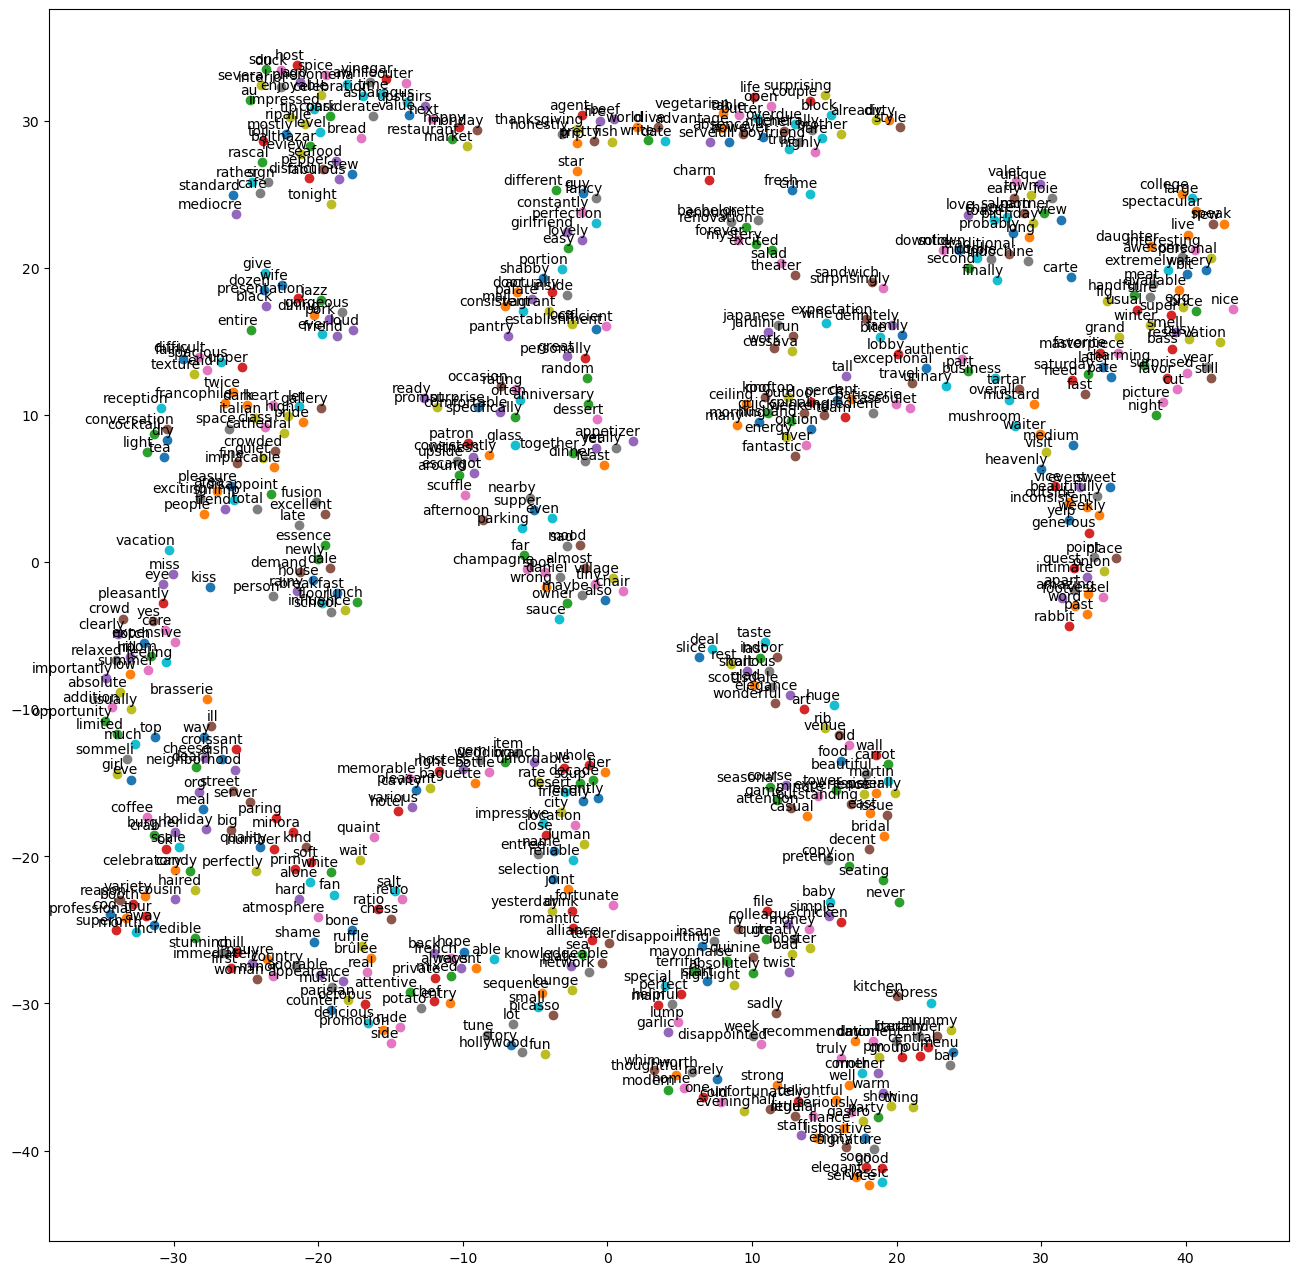

In [73]:
# We display a tsne plot of the word vectors
def tsne_plot(model):
    vocab = model.wv.index_to_key

    print(vocab)

    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in vocab:
        tokens.append(model.wv[word])
        labels.append(word)
        #print(tokens)
        #print(labels)
    tokens = np.array(tokens)
    tsne_model = TSNE(perplexity=20, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)


    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    
    
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    

tsne_plot(model)

### Using Tensorboard

com6: To look at the tensorboard results, you will need to download the VS tensorboard module or go to the corresponding port on your localhost (and making sure that the port is not used).
Please find the analysis of the

In [40]:
file_name = "word2vec.model"
model = gensim.models.keyedvectors.KeyedVectors.load(file_name)

max_size = len(model.wv.index_to_key)-1

w2v = np.zeros((max_size,model.vector_size))

if not os.path.exists('projections'):
    os.makedirs('projections')
    
with open("projections/metadata.tsv", 'w+') as file_metadata:
    
    for i, word in enumerate(model.wv.index_to_key[:max_size]):
        
        #store the embeddings of the word
        w2v[i] = model.wv[word]
        
        #write the word to a file 
        file_metadata.write(word + '\n')

tf.compat.v1.disable_eager_execution()
sess = tf.compat.v1.InteractiveSession()

with tf.device("/cpu:0"):
    embedding = tf.Variable(w2v, trainable=False, name='embedding')

sess.run(tf.compat.v1.global_variables_initializer())

saver = tf.compat.v1.train.Saver()
writer = tf.compat.v1.summary.FileWriter('projections', sess.graph)
config = projector.ProjectorConfig()
embed= config.embeddings.add()

embed.tensor_name = 'embedding'
embed.metadata_path = 'metadata.tsv'

projector.visualize_embeddings(writer, config)
saver.save(sess, 'projections/word2vec.ckpt', global_step=max_size)

2024-01-21 15:35:47.098242: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
/Users/alexandrecogordan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/tensorflow/python/client/session.py:1770: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
2024-01-21 15:35:47.098269: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


'projections/model.ckpt-1434'

In [41]:
def semantic_search(query_word, model, topn=10):
    query_vector = model.wv[query_word]
    all_words = model.wv.index_to_key

    # Calculate cosine distance between query and all other words
    distances = {word: cosine(query_vector, model.wv[word]) for word in all_words}
    
    # Sort words by distance (lower is more similar)
    sorted_words = sorted(distances, key=distances.get)

    # Return the topn closest words
    return sorted_words[:topn]

# Example usage
search_results = semantic_search('wine', word2vec_model)

search_results

['wine',
 'food',
 'french',
 'alliance',
 'great',
 'night',
 'staff',
 'restaurant',
 'good',
 'server']

### Tensorboard

Should we add a tensorboard?

## TF-IDF

In [16]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(generated_df['cleaned_text'])

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, generated_df['sentiment'], test_size=0.2, random_state=42)

classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print(classification_report(y_test, y_pred))

def classify_review(review_text):
    # Preprocess the review_text similar to your training data preprocessing
    preprocessed_text = preprocessing(review_text)  # Implement this function based on your preprocessing steps
    
    # Transform the review text to TF-IDF features
    tfidf_features = tfidf_vectorizer.transform([preprocessed_text])
    
    # Predict the label
    predicted_label = classifier.predict(tfidf_features)
    
    return predicted_label

classify_review("This is a great restaurant! I loved the food and the service was amazing.")


              precision    recall  f1-score   support

           1       0.96      0.98      0.97       102
           2       0.89      0.95      0.92       102
           3       0.93      0.84      0.88        85

    accuracy                           0.93       289
   macro avg       0.93      0.92      0.92       289
weighted avg       0.93      0.93      0.93       289



array([3])

In [17]:
from sklearn.pipeline import make_pipeline
import joblib

pipeline = make_pipeline(TfidfVectorizer(), RandomForestClassifier(n_estimators=100, random_state=42))

# Fit the pipeline with your data
pipeline.fit(generated_df['cleaned_text'], generated_df['sentiment'])

# Save the pipeline
joblib.dump(pipeline, 'review_classification_pipeline.joblib')

['review_classification_pipeline.joblib']

## Tensorboard

In [27]:
from sklearn.decomposition import TruncatedSVD
import numpy as np
import tensorflow as tf
from tensorboard.plugins import projector

# Assuming X_tfidf is your TF-IDF matrix
svd = TruncatedSVD(n_components=50, random_state=42)  # Reduce to 50 dimensions
X_reduced = svd.fit_transform(X_tfidf)

# Create a projection directory
if not os.path.exists('projections'):
    os.makedirs('projections')

# Save the reduced embeddings and feature names
with open("projections/metadata.tsv", 'w+') as file_metadata:
    # Use get_feature_names_out() for scikit-learn 0.24 and newer
    for feature_name in tfidf_vectorizer.get_feature_names_out():
        file_metadata.write(feature_name + '\n')

# TF-IDF embeddings after dimensionality reduction
tfidf_embeddings = np.array(X_reduced)

# Disable eager execution (needed for TensorBoard in TF1.x)
tf.compat.v1.disable_eager_execution()

# Start an interactive session
sess = tf.compat.v1.InteractiveSession()

# Create a TensorFlow variable for the embeddings
with tf.device("/cpu:0"):
    embedding_var = tf.Variable(tfidf_embeddings, trainable=False, name='tfidf_embedding')

# Initialize the variable
sess.run(tf.compat.v1.global_variables_initializer())

# Save the embeddings in a checkpoint
saver = tf.compat.v1.train.Saver([embedding_var])  # Add embedding_var to the saver
writer = tf.compat.v1.summary.FileWriter('projections', sess.graph)

# Setup the projector configuration
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name
embedding.metadata_path = 'metadata.tsv'

# Visualize embeddings
projector.visualize_embeddings(writer, config)
saver.save(sess, 'projections/tfidf.ckpt')

2024-01-20 15:08:02.257800: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-20 15:08:02.257862: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/alexandrecogordan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/tensorflow/python/client/session.py:1770: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


'projections/tfidf.ckpt'

In [5]:
import streamlit as st

def resize_image(image_path, width, height):
    image = Image.open(image_path)
    resized_image = image.resize((width, height))
    return resized_image

st.set_page_config(page_title="Gastonomy", page_icon="🍽️", layout="wide")
    
st.sidebar.markdown("Select a city and a restaurant to generate a review.")
city = st.sidebar.selectbox("City", sorted(df['location'].unique()))

# Dictionary mapping city names to image filenames
city_images = {
    'New Orleans': 'resources/new-orleans.jpg',
    'New York City': 'resources/new-york.jpg',
    'Chicago': 'resources/chicago.jpg',
    'Los Angeles': 'resources/los-angeles.jpg',
    'San Francisco': 'resources/san-francisco.jpg',
    'Philadelphia': 'resources/philadelphia.jpg',
    'Las Vegas': 'resources/las-vegas.jpg',
    'Houston': 'resources/houston.jpg',
    'Phoenix': 'resources/phoenix.jpg',
    'Miami': 'resources/miami.jpg'
}

# Display image based on selected city
if city in city_images:
    image_filename = city_images[city]
    resized_image = resize_image(image_filename, 1920, 1080)
    st.image(resized_image, caption=city)
else:
    st.write("Image not found for selected city.")

st.title("Restaurant Review Analysis")

st.header("Quel sont les aspects les plus importants pour vous dans un restaurant?")
topics = st.multiselect("Choisissez vos aspects", sorted(label_dict.keys()))

2024-01-17 16:33:50.937 
  command:

    streamlit run /Users/alexandrecogordan/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]


A faire: Faire choisir a l'utilisateur un ou des topics qu'il aimerait aborder. (S'il est interesse par le food quality par exemple on lui recommandera un restaurant avec une tres bonne food quality - peux-t-on recuperer les restaurants qui correspondent aux avis?).

Montrer aussi les topics principaux les plus importants pour les resturants francais de chaque ville

Later on, maybe use these topics to enhance the importance of them in summarised reviews.

What I suggest is this: Topics principaux par villes. On demande a l'utilisateur de choisir ce qu'il prefere a travers un chatbot et ensuite on trouve les restaurants avec les meilleurs topics et de ce resturant on montre aussi ses meilleurs atouts avec les topics.